In [1]:
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape , Conv2D, MaxPooling2D, UpSampling2D , Cropping2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os

def load_images_from_directory(directory):
    images = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)
                image = load_img(img_path, target_size=(128, 128))  # Resize image
                image_array = img_to_array(image)  # Convert to NumPy array
                image_array /= 255.0  # Normalize pixel values to [0, 1]
                images.append(image_array)
    return np.array(images)

# Load images for x and y
x = []
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA"))
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark/trainA"))
x.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainA"))

y = []
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainB"))
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark/trainB"))
y.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainB"))

# Convert lists to numpy arrays
x_array = np.array(x)
y_array = np.array(y)

print(f"x_array shape: {x_array.shape}")
print(f"y_array shape: {y_array.shape}")


x_array shape: (17563, 128, 128, 3)
y_array shape: (17563, 128, 128, 3)


In [2]:
test_data = []
test_data.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/test_samples/Inp"))
test_data.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/test"))

test_data_arr = np.array(test_data)
print(f"test_data_arr shape: {test_data_arr.shape}")

test_data_arr shape: (2328, 128, 128, 3)


In [3]:
#Try 1
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.Model(inputs, outputs)
    return model

model = unet()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [5]:
history = model.fit(
    x_array, y_array,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
    )


Epoch 1/50


I0000 00:00:1733583484.479274      96 service.cc:145] XLA service 0x7ab4e8002b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733583484.480055      96 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733583484.480064      96 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733583523.223771      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


440/440 ━━━━━━━━━━━━━━━━━━━━ 207s 374ms/step - accuracy: 0.5308 - loss: 0.0245 - val_accuracy: 0.6726 - val_loss: 0.0068
Epoch 2/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 143s 324ms/step - accuracy: 0.6047 - loss: 0.0089 - val_accuracy: 0.6753 - val_loss: 0.0072
Epoch 3/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 141s 321ms/step - accuracy: 0.6122 - loss: 0.0085 - val_accuracy: 0.6816 - val_loss: 0.0079
Epoch 4/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 141s 321ms/step - accuracy: 0.6167 - loss: 0.0085 - val_accuracy: 0.6726 - val_loss: 0.0065
Epoch 5/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 141s 321ms/step - accuracy: 0.6381 - loss: 0.0080 - val_accuracy: 0.6848 - val_loss: 0.0109
Epoch 6/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 141s 320ms/step - accuracy: 0.6412 - loss: 0.0084 - val_accuracy: 0.6531 - val_loss: 0.0077
Epoch 7/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 140s 319ms/step - accuracy: 0.6432 - loss: 0.0079 - val_accuracy: 0.6583 - val_loss: 0.0060
Epoch 8/50
440/440 ━━━━━━━━━━━━━━━━━━━━ 140s 318ms/step - accuracy: 0.6415 - loss: 0.00

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step


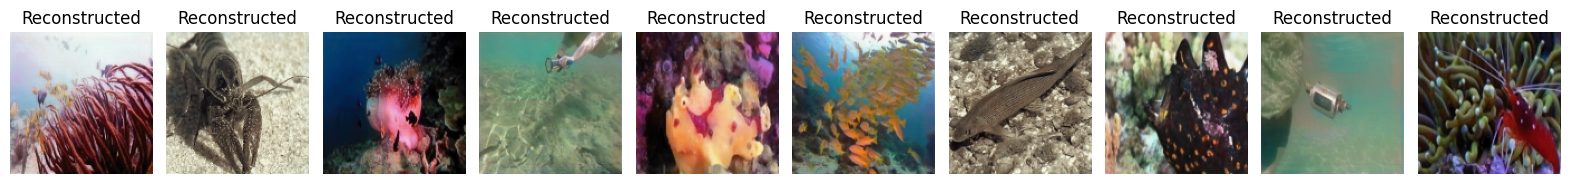

In [18]:
import matplotlib.pyplot as plt

# Generate predictions from the model for visualization
decoded_imgs = model.predict(test_data_arr) 

# Set the number of images to display
n = 10  # Adjust based on your preference

# Create a larger figure for better visualization
plt.figure(figsize=(20, 10))

# Adjust spacing between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(n):
    # # Original poor-quality image
    # ax = plt.subplot(3, n, i + 1)
    # plt.imshow(x_array[i].astype("float32"))
    # plt.title("Original")
    # plt.axis("off")
    
    # # Ground truth enhanced image
    # ax = plt.subplot(3, n, i + n + 1)
    # plt.imshow(y_array[i].astype("float32"))
    # plt.title("Ground Truth")
    # plt.axis("off")
    
    # Model's reconstructed (enhanced) image
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


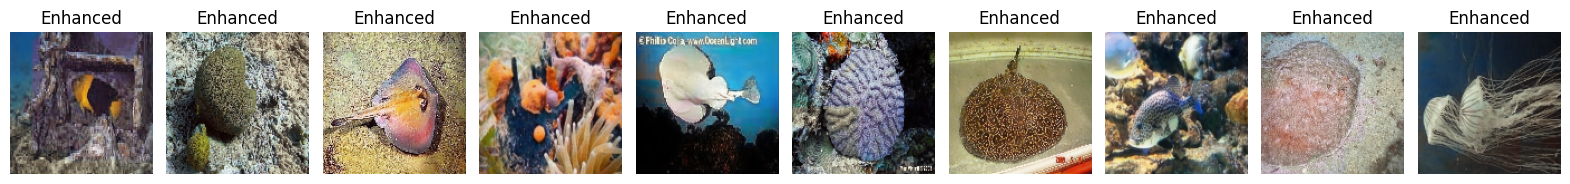

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Shuffle the test data for random selection
random_indices = np.random.choice(test_data_arr.shape[0], size=10, replace=False)
random_test_samples = test_data_arr[random_indices]

# Generate predictions for the randomly selected test samples
decoded_imgs = model.predict(random_test_samples)

# Set the number of images to display
n = 10  # Number of images to display

# Create a larger figure for better visualization
plt.figure(figsize=(20, 5))

# Adjust spacing between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(n):
    # Model's reconstructed (enhanced) image
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Enhanced")
    plt.axis("off")

plt.show()
